<a href="https://colab.research.google.com/github/orekhovsky/YSDA/blob/main/ML_2_spring2025/Homeworks/3/image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Лабораторная работа Image Captioning**
*Naumov Anton (Any0019)*

*To contact me in telegram: @any0019*

## Задание
В данном задании вашей задачей будет построить простую модель для задачи **Image Captioning** - по изображению (image) сгенерировать текстовый заголовок (caption).
Задание проверяется в автоматическом режиме в Я.Контест.

В задании будет несколько оцениваемых частей:
1. **Подготовка данных для модели** (*4 балла*) --> требуется заполнить пропуски и составить пайплайн предобработки данных
2. **Построение модели** (*3 балла*) --> требуется заполнить пропуски и составить пайплайн сборки модели
3. **Обучение модели** (*3 балла*) --> требуется заполнить пропуски и составить пайплайн обучения модели
4. **Оценка результатов** (*2 балл*) --> требуется заполнить пропуски и получить предсказания модели
5. **Валидация качества** (*3+ баллов*) --> вам нужно будет обучить модель, чтобы превзойти определённые пороги на валидационной выборке. Эта часть задания подразумевает возможность получения дополнительных баллов: в остальном ноутбуке вы соберёте модель по некоторой моей рекомендации, а именно в этой части от вас мы ожидаем экспериментов. Попробуйте собрать свою модель, улучшить качество, попробовать другие архитектуры и концептуальные подходы, в общем - удачи! За хорошие попытки полагаются баллы сверх базовой стоимости дз.

**Структура данных:**
- Вместе с заданием вам предложен файл __dataset.tar.gz__ (смотрите первую ячейку кода в ноутбуке), в нём вы найдёте папку data, в которой присутствуют две папки с изображениями (**train** и **val**) в формате .png и два файла **captions_train.tsv** и **captions_val.tsv**
- В файлах captions находятся таблицы с 6 полями, разделёнными через **\t**, содержащими `img_id` (название файла с изображением в соответствующей папке) и `caption #1-#5` (5 текстовых заголовков для изображения __img_id__)
- Не используйте val в обучении модели, только в тестах, т.к. часть баллов в конце будет выдаваться в зависимости от результатов вашей модели на test выборке, а проверка на val выборке - единственный способ оценки и само-проверки перед отправкой в контест на test замер

**Концепция простой модели**
- Будем рассматривать задачу предсказания следующего слова в предложении, имея изображение и предыдущие слова
- Для получения фичей из изображений будем использовать крупную свёрточную предобученную архитектуру
- Для получения фичей из текста будем использовать рекуррентную архитектуру с предобученными эмбеддингами, но чтобы передать внутрь этой модельки информацию из изображений будем в качестве hidden_0 передавать в них приведённые линейным слоем к нужному размеру фичи изображений
- Классификатор, завершающийся линейным слоем к размеру словаря над финальным набором фичей
- LogSoftmax + NLLLoss (или CrossEntropyLoss) для оценки предсказания

**Модели большие, подсчёты не быстрые - закладывайте время на обучение моделей**

**В ноутбуке будет какое-то количество assert-ов, их задача - подсказать вам, но совсем не всегда вы должны строго их проходить**

------------------------------

***Полезный комментарий:***

*Местами, в коде вы будете встречать выполнение bash скриптов - их легко распознать по комментарию `#!:bash` вверху ячейки.*

*Если вы пользуетесь датосферой, то оставьте как есть, всё сработает, а вот если Google colab или что-то ещё, то замените код скриптов так, чтобы каждая его строка начиналась с `!`.*

*К примеру:*

*Изначальный блок:*
```bash
#!:bash
ls -sh dataset.tar
file dataset.tar
```

*Заменённый блок:*
```bash
!ls -sh dataset.tar
!file dataset.tar
```

...вроде как сейчас второй вариант так же работает и в датасфере, но я не уверен

## 0. Скачиваем и распаковываем данные

In [1]:
import requests
from urllib.parse import urlencode

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/W9EODR61Dj1Oxg'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('dataset.tar.gz', 'wb') as f:   # Здесь укажите нужный путь к файлу
    f.write(download_response.content)

## 1. Подготовка данных (***4 балла***)

In [2]:
#!:bash
!ls -sh dataset.tar.gz
!file dataset.tar.gz

2.2G dataset.tar.gz
dataset.tar.gz: gzip compressed data, from Unix, original size modulo 2^32 2370375680


In [3]:
#!:bash
!tar xfz dataset.tar.gz -C .

In [4]:
import torch
import cv2
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data_folder = "./data"  # укажите здесь путь до распакованных данных

dfs = dict()
for split in ['train', 'val']:
    dfs[split] = pd.read_csv(os.path.join(data_folder, f'captions_{split}.tsv'), sep='\t')

dfs['train'].head()

img_id                                         caption #0  \
0  0000.png  A child in a pink dress is climbing up a set o...   
1  0001.png         A black dog and a spotted dog are fighting   
2  0002.png  A little girl covered in paint sits in front o...   
3  0003.png  A man lays on a bench while his dog sits by him .   
4  0004.png     A man in an orange hat starring at something .   

                                          caption #1  \
0              A girl going into a wooden building .   
1  A black dog and a tri-colored dog playing with...   
2  A little girl is sitting in front of a large p...   
3  A man lays on the bench to which a white dog i...   
4            A man wears an orange hat and glasses .   

                                          caption #2  \
0   A little girl climbing into a wooden playhouse .   
1  A black dog and a white dog with brown spots a...   
2  A small girl in the grass plays with fingerpai...   
3  a man sleeping on a bench outside with a white...   
4  A man with gauges and glasses is wearing a Bli...   

                                          caption #3  \
0  A little girl climbing the stairs to her playh...   
1  Two dogs of different breeds looking at each o...   
2  There is a girl with pigtails sitting in front...   
3  A shirtless man lies on a park bench with his ...   
4  A man with glasses is wearing a beer can croch...   

                                          caption #4  
0  A little girl in a pink dress going into a woo...  
1    Two dogs on pavement moving toward each other .  
2  Young girl with pigtails painting outside in t...  
3  man laying on bench holding leash of dog sitti...  
4  The man with pierced ears is wearing glasses a...

In [6]:
dfs['train'].shape

(6000, 6)

In [7]:
dfs['val'].shape

(500, 6)

<class 'numpy.ndarray'>
(375, 500, 3)


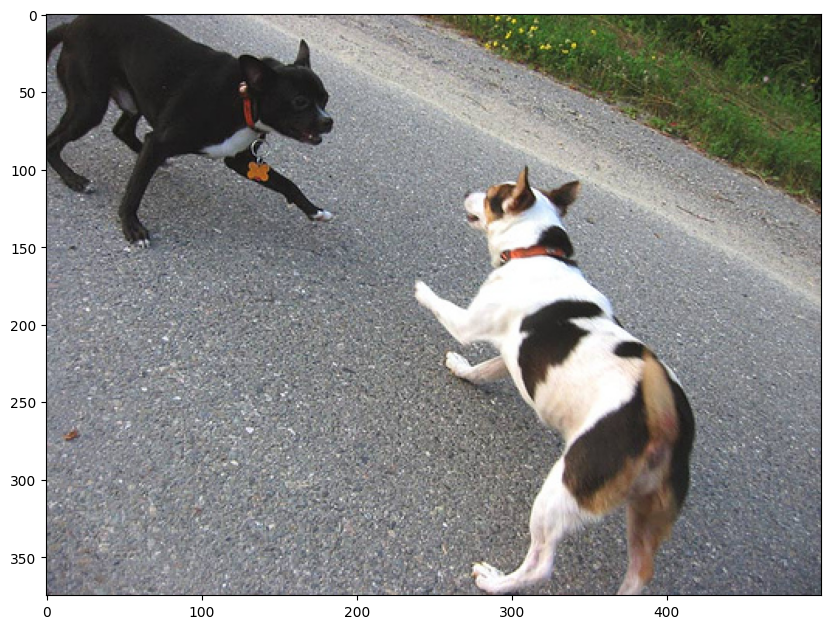

In [8]:
fig, ax = plt.subplots(figsize=(10,8))
# Для чтения изображений из файлов мы будем использовать библиотеку cv2 --> всё что вам нужно знать
#   функция cv2.imread(path) принимает на вход путь к файлу изображения и возвращает np.array с изображением
#   в порядке h x w x c
image = cv2.imread(os.path.join(data_folder, 'train', '0001.png'))
print(type(image))
print(image.shape)
plt.imshow(image)
plt.show()

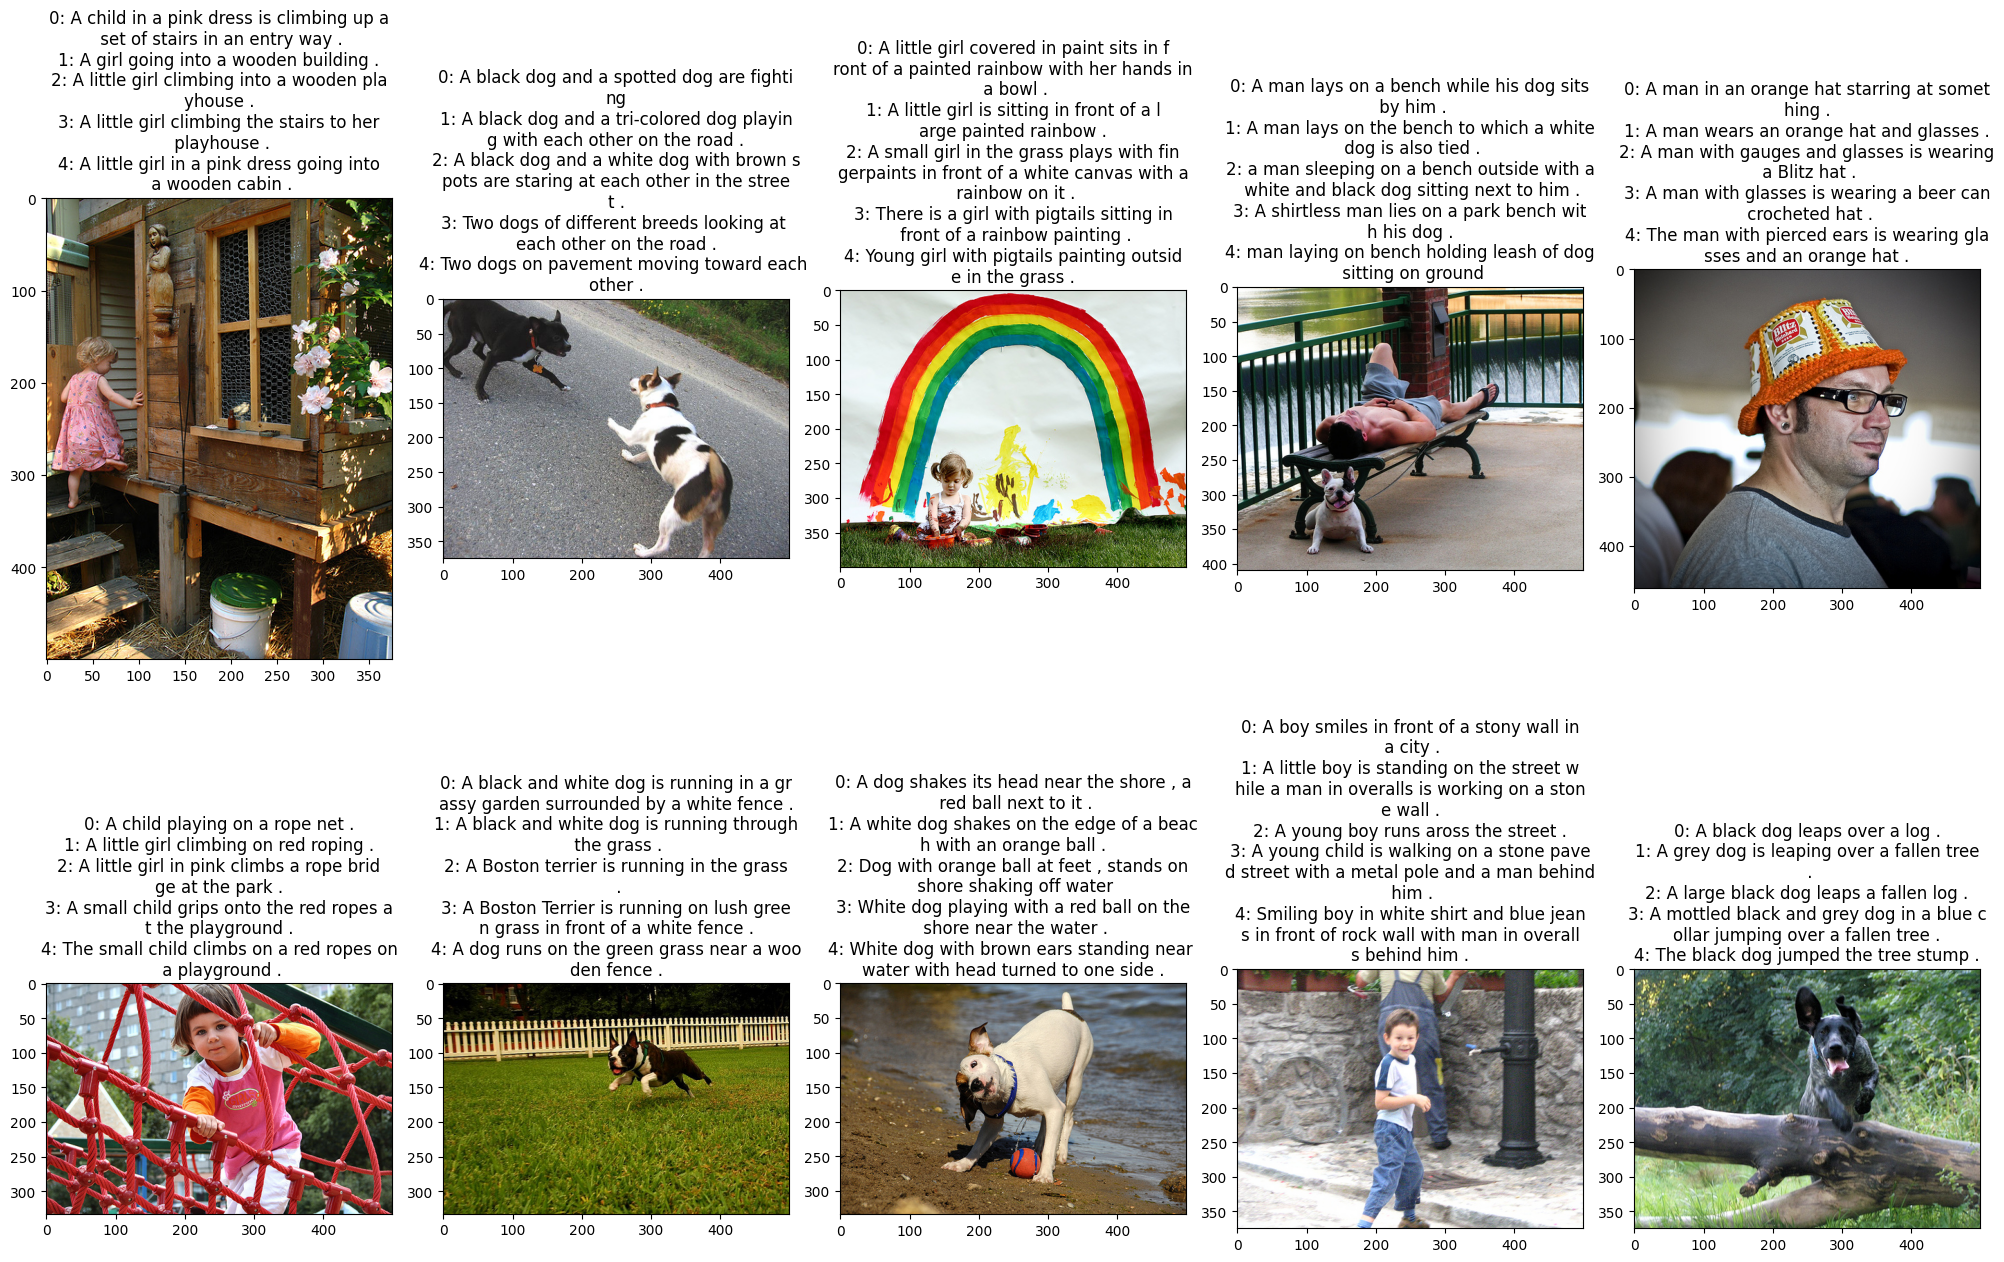

In [9]:
inds = list(range(10))
split = 'train'

h, w = 2, 5
title_width = 43

assert h*w >= len(inds)

fig, ax = plt.subplots(h, w, figsize=(20, 15))

for i, ind in enumerate(inds):
    row = dfs[split].iloc[ind]
    img_id = row['img_id']
    captions = [row[f'caption #{i}'] for i in range(5)]

    caption_adjasted = map(lambda el: '\n'.join([(str(el[0]) + ': ' + el[1])[k:k+title_width] for k in range(0, 3 + len(el[1]), title_width)]), enumerate(captions))
    caption = '\n'.join(caption_adjasted)
    plt.subplot(h, w, i+1)
    plt.title(caption)
    plt.imshow(cv2.imread(os.path.join(data_folder, split, img_id)))

fig.tight_layout()
plt.show()

### 1.2 Предобработка изображений

**Сперва напишем предобработку для изображений**

In [10]:
import os
import cv2
import numpy as np
from tqdm import tqdm

train_folder = os.path.join(data_folder, 'train')
img_files = os.listdir(train_folder)

channel_mean = np.zeros(3)
channel_std = np.zeros(3)

for img_file in tqdm(img_files):
  img_path = os.path.join(train_folder, img_file)
  img = cv2.imread(img_path)
  img =  img/255.0

  channel_mean += img.mean(axis=(0,1))
  channel_std += img.std(axis=(0,1))

channel_mean /= len(img_files)
channel_std /= len(img_files)

print(channel_mean)
print(channel_std)

100%|██████████| 6000/6000 [02:19<00:00, 43.05it/s]

[0.45802264 0.44634529 0.40322752]
[0.24192556 0.23314284 0.23692942]


In [11]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tr

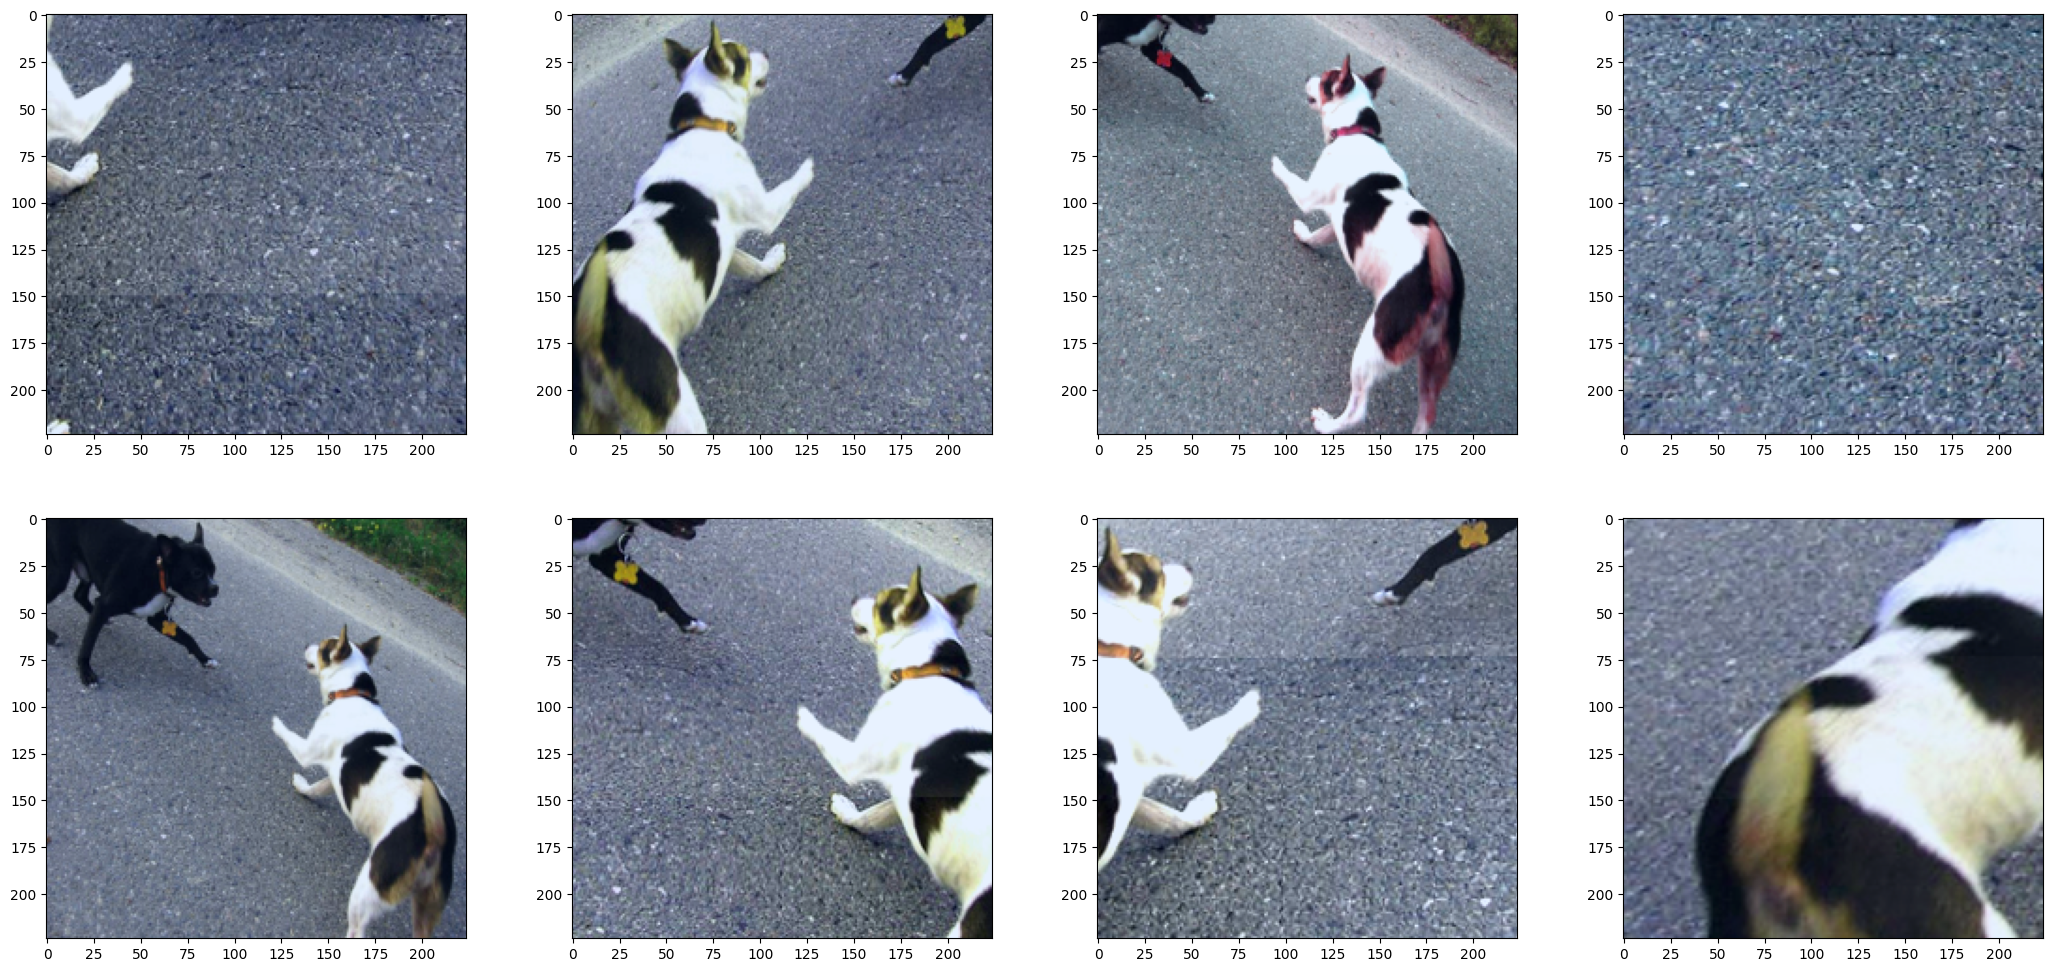

In [12]:
# Подготовьте функцию для аугументации одного изображения

# !!! Напомню, что в выборе аугументаций многое будет зависеть от того,
# !!!  на каких аугументациях училась предобученная модель, которую вы возьмёте,
# !!!  так что рекомендую принимать решение о финальных аугументациях после изучения
# !!!  выбранной вами модели

# Поканальное среднее и стандартное отклонение (как и откуда лучше взять?)
channel_mean = np.array([0.485, 0.456, 0.406])
channel_std = np.array([0.229, 0.224, 0.225])

image_prepare = tr.Compose([
    tr.ToPILImage(),
    tr.RandomResizedCrop(224),
    tr.RandomHorizontalFlip(p=0.5),
    tr.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    tr.ToTensor(),
    tr.Normalize(mean=channel_mean, std=channel_std),
])

# Для валидации рекомендую использовать минимальное количество аугументаций, чтобы
#  замеряться честно - изменения размера, нормализация (все случайные аугументации
#  не делайте для валидации и обязательно для обучения делайте со средним в нуле)
image_prepare_val = tr.Compose([
    tr.ToPILImage(),
    tr.Resize(256),
    tr.CenterCrop(224),
    tr.ToTensor(),
    tr.Normalize(mean=channel_mean, std=channel_std),
])


# Визуализация ваших преобразований на одном изображении (проверка на адекватность)
from sklearn.preprocessing import minmax_scale

image = cv2.imread(os.path.join(data_folder, "train", "0001.png"))

def de_normalize(img):
    return minmax_scale(
        (img.reshape(3, -1) + channel_mean[:, None]) * channel_std[:, None],
        feature_range=(0., 1.),
        axis=1,
    ).reshape(*img.shape)

# Проверка на адекватность
fig, ax = plt.subplots(2, 4, figsize=(26, 12))
for i in range(8):
    plt.subplot(2, 4, i+1)
    transformed_image = image_prepare(image).numpy().transpose(1, 2, 0)
    to_show_image = de_normalize(transformed_image)
    plt.imshow(to_show_image)
plt.show()

### 1.3 Предобработка заголовков

**Затем напишем предобработку для заголовков**

Для простоты вычислений предлагаю сделать крайне простую токенизацию, пользуясь регулярными выражениями и библиотекой **re**

1. Приводим текст к нижнему регистру
2. Заменяем всю пунктуацию на пробелы
3. Убираем пробельные символы с концов строки
4. Разбиваем по ненулевой последовательности пробельных символов
5. Добавляем специальные токены \<BOS> (begining of sentence) и \<EOS> (end of sentence), чтобы обозначить границы заголовка для модели

In [13]:
import re

def tokenize(text):
    text = text.lower()  # Приводим к нижнему регистру
    text = re.sub(r"[^\w\s]", " ", text)  # Заменяем всю пунктуацию на пробелы
    text = text.strip()  # Убираем пробелы с концов строки
    tokens = text.split()  # Разбиваем по последовательности пробелов
    return ["<BOS>"] + tokens + ["<EOS>"]  # Добавляем спецтокены

# Проверка
print(tokenize("My name is Any0019, I wish you good luck in this lab! Bye-bye :)"))


['<BOS>', 'my', 'name', 'is', 'any0019', 'i', 'wish', 'you', 'good', 'luck', 'in', 'this', 'lab', 'bye', 'bye', '<EOS>']


Соберём словарь из всех слов, что встречаются в заголовках в train
1. Токенизируем заголовки
2. Обновляем частоту всех отдельных токенов
3. Выкидываем все слова встретившиеся меньше `MIN_FREQ` (допустим 3 - можете взять другое число) -> заменяем на специальный `<UNK>` (unknown) токен
4. Записываем быстрое преобразование из токенов в индексы и наоборот

In [14]:
from tqdm.auto import trange
from collections import Counter

vocab_freq = Counter()
sizes = Counter()

for i in trange(len(dfs['train'])):
  for col in ['caption #0', 'caption #1', 'caption #2', 'caption #3', 'caption #4']:
    tokens = tokenize(dfs['train'].iloc[i][col])
    vocab_freq.update(tokens)

print(vocab_freq.most_common(10))

  0%|          | 0/6000 [00:00<?, ?it/s]

[('a', 46784), ('<BOS>', 30000), ('<EOS>', 30000), ('in', 14094), ('the', 13509), ('on', 8007), ('is', 6907), ('and', 6678), ('dog', 6160), ('with', 5763)]


In [ ]:
# MIN_FREQ = 3  # Порог отсечения

# # Создадим новый словарь, где останутся только частотные слова
# filtered_vocab = {word: count for word, count in vocab_freq.items() if count >= MIN_FREQ}

# # Добавим специальный токен <UNK> (неизвестное слово)
# filtered_vocab["<UNK>"] = sum(count for word, count in vocab_freq.items() if count < MIN_FREQ)

# print(f"Размер словаря после фильтрации: {len(filtered_vocab)}")

Размер словаря после фильтрации: 3477


  0%|          | 0/6000 [00:00<?, ?it/s]

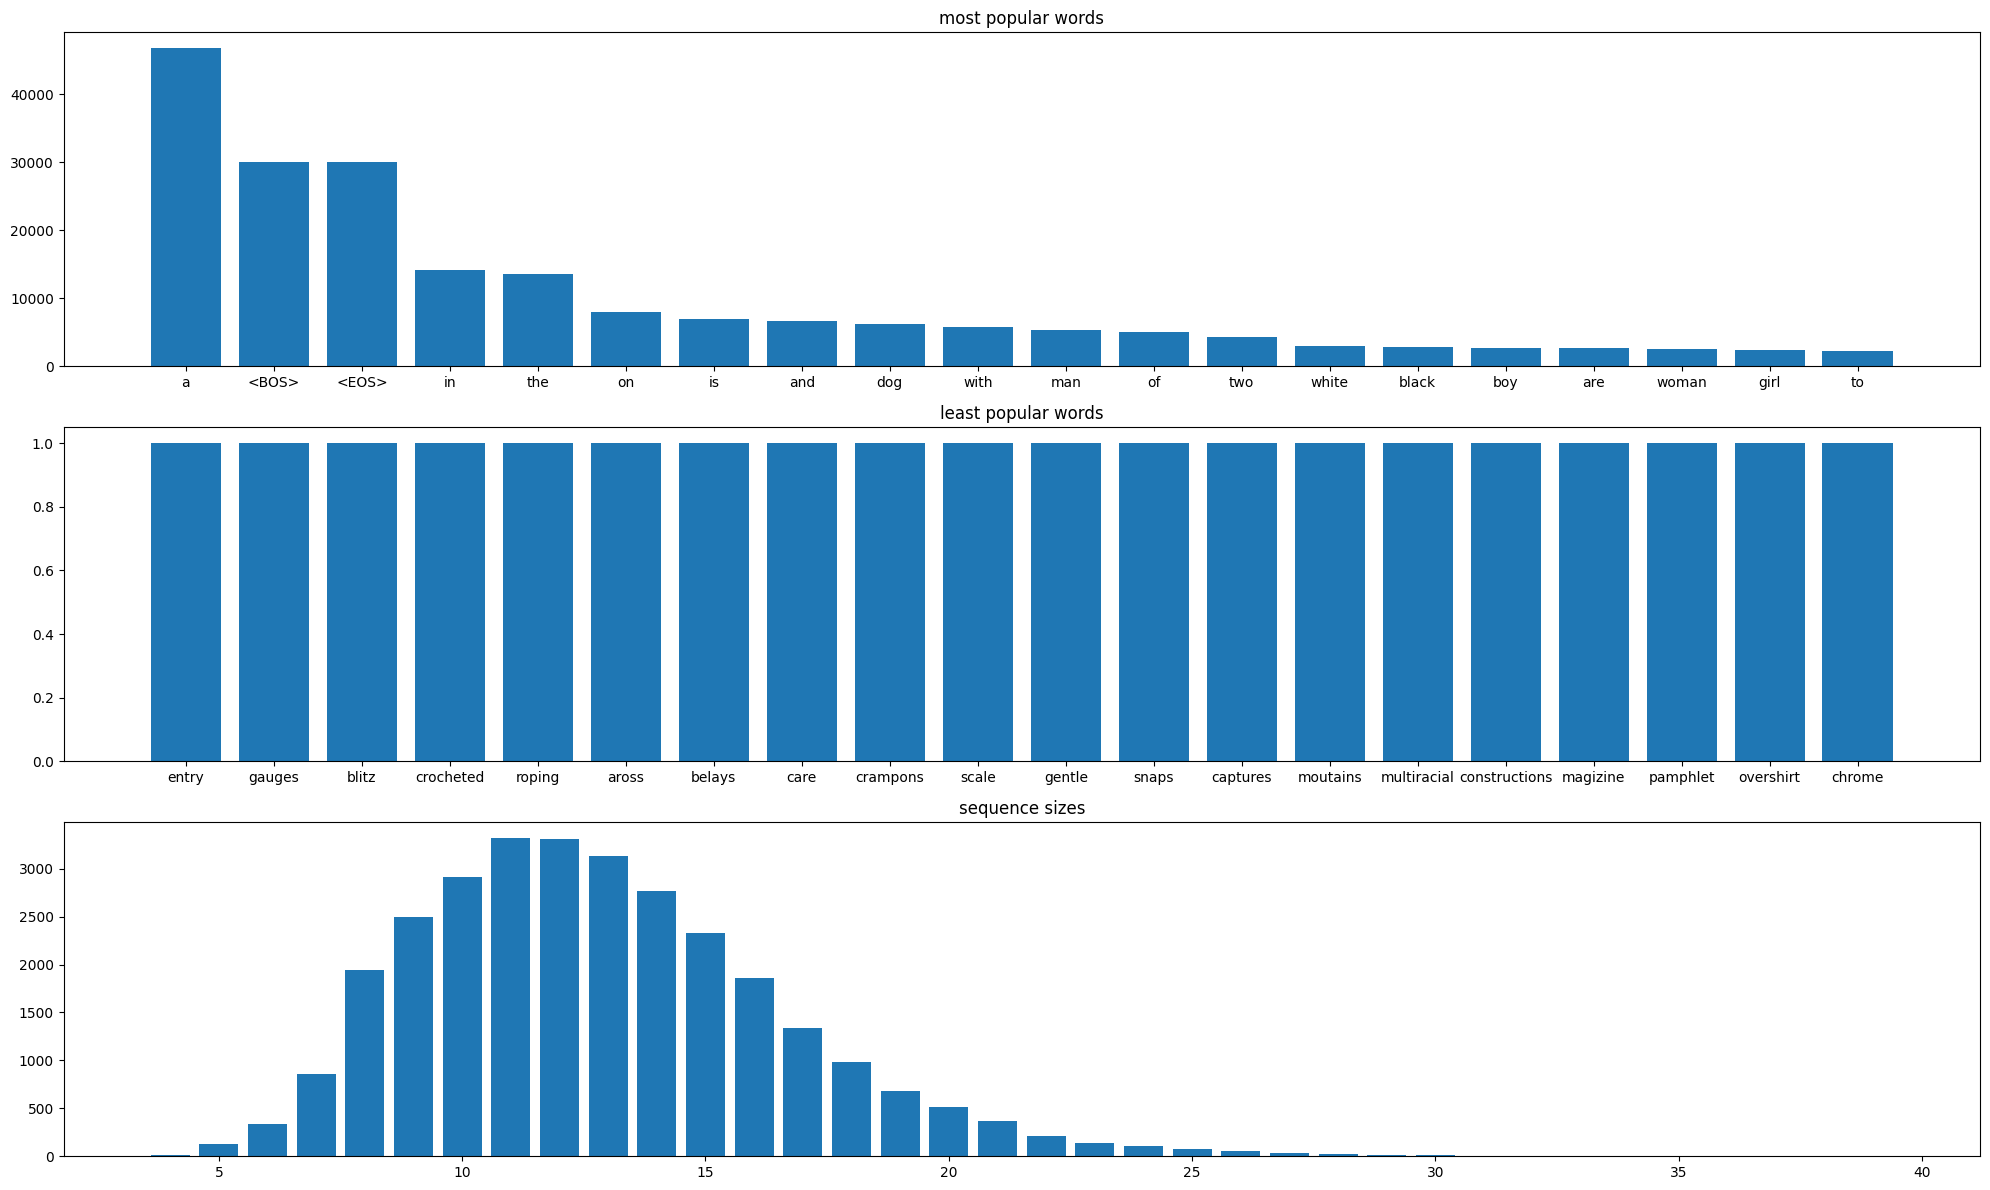

In [15]:
from tqdm.auto import trange
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# Посчитаем частоту встречаемости различных токенов (не нужно для bos и eos)
vocab_freq = Counter()

# Параллельно заодно посчитаем длины заголовков в токенах (сколько раз встречалась какая длина в токенах)
# sizes[5] = число заголовков из 5 токенов (без учёта bos и eos)
sizes = Counter()

for i in trange(len(dfs['train'])):
    for col in ['caption #0', 'caption #1', 'caption #2', 'caption #3', 'caption #4']:
        tokens = tokenize(dfs['train'].iloc[i][col])
        vocab_freq.update(tokens)

        # Добавляем длину текущего заголовка в sizes
        sizes[len(tokens)] += 1

# Найдем максимальную длину последовательности
global_max_seq_len = np.max(list(sizes.keys())) if sizes else 0

# Визуализация
show_ = 20
fig, ax = plt.subplots(3, 1, figsize=(20, 12))

# Показ самых редких слов
plt.subplot(312)
vocab_freq = {k: v for k, v in sorted(vocab_freq.items(), key=lambda item: item[1])}
plt.title('least popular words')
plt.bar(list(vocab_freq.keys())[:show_], list(vocab_freq.values())[:show_])

# Показ самых популярных слов
plt.subplot(311)
vocab_freq = {k: v for k, v in sorted(vocab_freq.items(), key=lambda item: item[1], reverse=True)}
plt.title('most popular words')
plt.bar(list(vocab_freq.keys())[:show_], list(vocab_freq.values())[:show_])

# Показ размеров последовательностей
plt.subplot(313)
plt.title('sequence sizes')
plt.bar(list(sizes.keys()), list(sizes.values()))

fig.tight_layout()
plt.show()

In [16]:
MIN_FREQ = 3  # токены с частотой ниже этой константы заменяются на <UNK>

# Так же добавляем <PAD> токен для паддингов
tok_to_ind = {
    '<UNK>': 0,
    '<BOS>': 1,
    '<EOS>': 2,
    '<PAD>': 3,
}

ind_to_tok = {
    0: '<UNK>',
    1: '<BOS>',
    2: '<EOS>',
    3: '<PAD>',
}

# Заполняем оставшиеся токены
current_index = 4  # Следующий доступный индекс после специальных токенов

for token, freq in vocab_freq.items():
    if freq >= MIN_FREQ and token not in tok_to_ind:
        tok_to_ind[token] = current_index
        ind_to_tok[current_index] = token
        current_index += 1

assert len(tok_to_ind) == len(ind_to_tok)
vocab_size = len(tok_to_ind)
print(f"Resulting vocab size: {vocab_size} (out of {len(vocab_freq)} tokens overall, due to MIN_FREQ={MIN_FREQ})")

Resulting vocab size: 3478 (out of 7372 tokens overall, due to MIN_FREQ=3)


In [17]:
# Функция возвращает по тексту индексы токенов в тексте
def to_ids(text):
    tokens = tokenize(text)
    ids =[]

    for token in tokens:
      if token in tok_to_ind:
        ids.append(tok_to_ind[token])
      else:
        ids.append(tok_to_ind['<UNK>'])
    return ids

text = "I really hope that you can get a lot of great results with this lab! You're awesome! I believe in you, good luck :)"
toks = tokenize(text)
ids = to_ids(text)

print(list(zip(toks, ids)))

assert toks[0] == '<BOS>' and toks[-1] == '<EOS>'
assert ids[0] == tok_to_ind['<BOS>'] and ids[-1] == tok_to_ind['<EOS>']

[('<BOS>', 1), ('i', 1372), ('really', 2343), ('hope', 0), ('that', 153), ('you', 1173), ('can', 760), ('get', 373), ('a', 4), ('lot', 384), ('of', 13), ('great', 2469), ('results', 0), ('with', 11), ('this', 313), ('lab', 1052), ('you', 1173), ('re', 0), ('awesome', 0), ('i', 1372), ('believe', 0), ('in', 5), ('you', 1173), ('good', 2454), ('luck', 0), ('<EOS>', 2)]


### 1.4 Датасет

**Сделаем класс датасета в стиле torch.utils.data.Dataset**

In [50]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, imgs_path, captions_path, train=True):
        super(ImageCaptioningDataset, self).__init__()
        self.imgs_path = imgs_path
        self.train = train

        # Загружаем подписи из файла
        self.captions_df = pd.read_csv(captions_path, sep='\t')

        # Проверяем имена столбцов
        print("Columns in captions file:", self.captions_df.columns)

        # Создаем словарь для хранения подписей
        self.captions_dict = {}

        # Проходим по всем строкам и собираем подписи
        for _, row in self.captions_df.iterrows():
            img_id = row['img_id']  # Или другой столбец с идентификатором изображения
            captions = [row[f'caption #{i}'] for i in range(5)]  # Собираем все 5 подписей
            self.captions_dict[img_id] = captions

        # Получаем список всех image_id
        self.image_ids = list(self.captions_dict.keys())

        # Трансформации для обучения и валидации
        self.transform_train = tr.Compose([
            tr.RandomResizedCrop(224),
            tr.RandomHorizontalFlip(p=0.5),
            tr.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            tr.ToTensor(),
            tr.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.transform_val = tr.Compose([
            tr.Resize(256),
            tr.CenterCrop(224),
            tr.ToTensor(),
            tr.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    def __getitem__(self, index):
        # Получаем image_id по индексу
        img_id = self.image_ids[index]

        # Загружаем изображение
        img_path = os.path.join(self.imgs_path, f"{img_id}")
        img = Image.open(img_path).convert('RGB')

        # Применяем преобразования к изображению
        if self.train:
            img = self.transform_train(img)
        else:
            img = self.transform_val(img)

        # Получаем все подписи для изображения
        captions = self.captions_dict[img_id]

        # Преобразуем все подписи в индексы токенов
        caption_ids = [to_ids(caption) for caption in captions]

        return img, caption_ids

    def __len__(self):
        return len(self.image_ids)

In [51]:
ds_train = ImageCaptioningDataset(
    os.path.join(data_folder, 'train'),
    os.path.join(data_folder, f'captions_train.tsv'),
    train=True,
)

ds_val = ImageCaptioningDataset(
    os.path.join(data_folder, 'val'),
    os.path.join(data_folder, f'captions_val.tsv'),
    train=False,
)

Columns in captions file: Index(['img_id', 'caption #0', 'caption #1', 'caption #2', 'caption #3',
       'caption #4'],
      dtype='object')
Columns in captions file: Index(['img_id', 'caption #0', 'caption #1', 'caption #2', 'caption #3',
       'caption #4'],
      dtype='object')


In [52]:
img1, captions1 = ds_train[0]
img2, captions2 = ds_train[1]

# Изображения должны быть тензорами (желательно одного размера для удобства складывания в батч)
assert isinstance(img1, torch.Tensor)
assert isinstance(img2, torch.Tensor)
assert img1.shape == img2.shape  # может быть не так, только если вы понимаете что делаете
assert img1.shape[0] == 3
print(f"Размер изображения из датасета: {img1.shape}")

# На этом этапе предлагаю возвращать просто list-ы captions без паддинга
assert isinstance(captions1, list)
assert isinstance(captions2, list)

# Если вы возвращаете все или >1 заголовков для каждого изображения
assert isinstance(captions1[0], list) and len(captions1) == len(captions2)
assert isinstance(captions1[0][0], int)
assert ind_to_tok[captions1[0][0]] == "<BOS>"
assert ind_to_tok[captions1[0][-1]] == "<EOS>"
print(f"Число заголовков для одного изображения: {len(captions1)}")

# Если вы возвращаете 1 случайный заголовок для каждого изоброажения
# assert isinstance(captions1[0], int)
# assert ind_to_tok[captions1[0]] == "<BOS>"
# assert ind_to_tok[captions1[-1]] == "<EOS>"

# Проверка что число элементов в датасете совпадает с соответствующим числом изображений
assert len(ds_train) == len(os.listdir(os.path.join(data_folder, 'train')))
assert len(ds_val) == len(os.listdir(os.path.join(data_folder, 'val')))

Размер изображения из датасета: torch.Size([3, 224, 224])
Число заголовков для одного изображения: 5


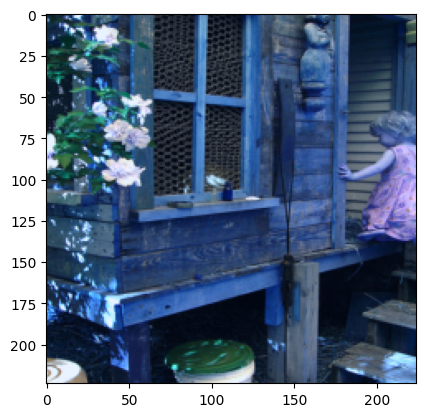

In [53]:
# Проверка на адекватность
plt.imshow(
    de_normalize(img1.numpy().transpose(1, 2, 0))
)
plt.show()

### 1.5 Даталоадер

In [60]:
# Здесь хотим задать кастомную функцию для того, как именно складывать данные в батч
# Эта функция позже будет передана в collate_fn аргумент даталоадера и будет отвечать за то,
#  как обработать батч и превратить его в тензоры нужного вида
import torch
from torch.nn.utils.rnn import pad_sequence
def collate_fn(batch):
    # Разделяем изображения и подписи
    imgs, captions = zip(*batch)

    # Складываем изображения в один тензор
    img_batch = torch.stack(imgs, dim=0)  # [batch_size, num_channels, height, width]

    # Обрабатываем подписи
    if isinstance(captions[0][0], list):  # Если возвращается несколько подписей для каждого изображения
        # Сначала собираем все подписи в один список
        all_captions = [caption for img_captions in captions for caption in img_captions]

        # Дополняем подписи до одинаковой длины
        captions_padded = pad_sequence(all_captions, batch_first=True, padding_value=tok_to_ind['<PAD>'])

        # Преобразуем в тензор [batch_size, num_captions_per_image, max_seq_len]
        captions_batch = captions_padded.view(len(captions), -1, captions_padded.size(-1))
    else:  # Если возвращается одна подпись для каждого изображения
        # Дополняем подписи до одинаковой длины
        captions_batch = pad_sequence(captions, batch_first=True, padding_value=tok_to_ind['<PAD>'])

    return img_batch, captions_batch

In [61]:
batch_size = 64
num_workers = 0

dataloader_train = DataLoader(
    dataset=ds_train,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

dataloader_val = DataLoader(
    dataset=ds_val,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [62]:
img_batch, captions_batch = next(iter(dataloader_train))

assert isinstance(img_batch, torch.Tensor)
assert isinstance(captions_batch, torch.Tensor)

assert img_batch.shape[:2] == torch.Size([batch_size, 3])
assert captions_batch.shape[0] == batch_size
assert len(captions_batch.shape) in [2, 3]

assert isinstance(captions_batch.reshape(-1)[0].item(), int)

print("Размер батча изображений: {}\nРазмер батча заголовков: {}".format(img_batch.shape, captions_batch.shape))

TypeError: expected Tensor as element 0 in argument 0, but got list

## 2. Составляем модель (***3 балла***)

[Картинка предложенной архитектуры модели для понимания](https://disk.yandex.ru/i/sHzk7LBP8-A5aQ)

<img src="https://disk.yandex.ru/i/sHzk7LBP8-A5aQ">

### 2.1 Фича-экстрактор для изображений

Возьмите какую-нибудь предобученную модель (к примеру resnet), по желанию заморозьте все или часть слоёв, наиболее вероятно уберите последний слой

```python
# выбрать веса нужной вам модели
weights = models.ResNet18_Weights.DEFAULT

# скачать нужную архитекутру модели и инициализировать её весами
model = models.resnet18(weights=weights, progress=True)

# посмотреть какие аугументации использовались в данной модели
weights.transforms()
```

In [ ]:
from torchvision import models
from torch import nn

In [ ]:
class img_fe_class(nn.Module):
    def __init__(self, ...):
        super(img_fe_class, self).__init__()
        ...

    def forward(self, imgs):
        ...

In [ ]:
img_fe = img_fe_class(...)

img_features = img_fe(img_batch)

assert len(img_features.shape) == 2
assert img_features.shape[0] == img_batch.shape[0]

print(f'Для изображения возвращает {img_features.shape[1]} фичей')

### 2.2 Фича-экстрактор для текста

Давайте скачаем предобученные glove вектора и инициализируем nn.Embedding ими, там где мы их знаем

In [ ]:
#!:bash
wget -O glove.zip https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip
# mirror https://nlp.stanford.edu/data/wordvecs/glove.840B.300d.zip

unzip glove.zip

ls -sh glove.*

In [ ]:
# Открываем glove
np.random.seed(19)

def load_glove_weights(file_path, vocab, pad_token="<PAD>"):
    print("Loading Glove Weights")
    # Инициализируем веса для всех слов стандартным нормальным распределением
    glove_weights = np.random.uniform(0, 1, (len(vocab), 300))
    mask_found = np.zeros(len(vocab), dtype=bool)

    # Ищем среди слов в предобученном glove слова из нашего словаря
    with open(file_path, 'r') as f:
        for line in tqdm(f, total=2196018):
            line = line.split()
            token = ' '.join(line[:-300])
            embed = line[-300:]

            # Если нашли, то подменяем эмбеддинг из glove
            if token in vocab:
                ind = vocab[token]
                mask_found[ind] = True
                glove_weights[ind, :] = np.array(list(map(float, embed)), dtype=np.float)

    print(f"{mask_found.sum()} words from vocab of size {len(vocab)} loaded!")

    glove_weights[vocab[pad_token]] = np.zeros(300, dtype=np.float)
    return glove_weights, mask_found


glove_path = "/home/jupyter/datasphere/project/Sem2 - NLP/glove.840B.300d.txt"
glove_weights, mask_found = load_glove_weights(glove_path, tok_to_ind, "<PAD>")

-----

Теперь, давайте составим рекурентную модельку для получения фичей из текстов с учётом картинок

Используйте эмбеддинги из картинок в качестве начального состояния скрытого слоя рекурентной нейросети (h_0), если размерности не совпадают, то линейный слой вам в помощь. Если в вашей rnn-like ячейке несколько слоёв, то подавайте в каждый из них.

Вам может пригодиться:

1. библиотека einops - один из самых удобных способов перетасовывать размерности в тензорах, пример:
```python
from einops import rearrange

a = torch.zeros(batch_size, num_captions, max_seq_length, emb_size)
b = rearrange(a, "bs cap seq emb -> (bs cap) seq emb")  # (batch_size * num_captions, max_seq_length, emb_size)
c = rearrange(b, "(bs cap) seq emb -> bs cap seq emb", cap=num_captions)  # (batch_size, num_captions, max_seq_length, emb_size)
```

2. torch.Tensor.repeat() - размножить тензор вдоль одной из размерностей, пример:
```python
a = torch.zeros(3, 5)
b = a[None, :, None, :]  # (1, 3, 1, 5)
c = b.repeat(2, 1, 4, 2)  # (2, 3, 4, 10)
```

In [ ]:
from einops import rearrange

class text_fe_class(nn.Module):
    def __init__(self, ...):
        super(text_fe_class, self).__init__()

        ...

        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=300, padding_idx=tok_to_ind['<PAD>'])
        self.embed.weight = nn.Parameter(
            torch.from_numpy(glove_weights).to(dtype=self.embed.weight.dtype),
            requires_grad=True,
        )

        ...

    def forward(self, texts, img_features):
        ...

In [ ]:
text_fe = text_fe_class(...)
text_features = text_fe(captions_batch, img_features)

assert text_features.shape[:-1] == captions_batch.shape
assert len(text_features.shape) in [3, 4]
assert len(text_features.shape) == len(captions_batch.shape) + 1

print(captions_batch.shape)
print(img_features.shape)
print(text_features.shape)

### 2.3 Финальная модель

In [ ]:
from collections import OrderedDict

class image_captioning_model(nn.Module):
    def __init__(self, ...):
        super(image_captioning_model, self).__init__()
        ...

    def forward(self, img_batch, texts_batch):
        ...

In [ ]:
model = image_captioning_model(...)

res = model(img_batch, captions_batch)

assert res.shape[:-1] == captions_batch.shape
assert res.shape[-1] == vocab_size

print(res.shape)

In [ ]:
from termcolor import colored
from collections import defaultdict

def beautiful_int(i):
    i = str(i)
    return ".".join(reversed([i[max(j, 0):j+3] for j in range(len(i) - 3, -3, -3)]))

# Считаем общее число параметров в нашей модели
def model_num_params(model, verbose_all=True, verbose_only_learnable=False):
    sum_params = 0
    sum_learnable_params = 0
    submodules = defaultdict(lambda : [0, 0])
    for name, param in model.named_parameters():
        num_params = np.prod(param.shape)
        if verbose_all or (verbose_only_learnable and param[1].requires_grad):
            print(
                colored(
                    '{: <42} ~  {: <9} params ~ grad: {}'.format(
                        name,
                        beautiful_int(num_params),
                        param.requires_grad,
                    ),
                    {True: "green", False: "red"}[param[1].requires_grad],
                )
            )
        sum_params += num_params
        sm = name.split(".")[0]
        submodules[sm][0] += num_params
        if param.requires_grad:
            sum_learnable_params += num_params
            submodules[sm][1] += num_params
    print(
        f'\nIn total:\n  - {beautiful_int(sum_params)} params\n  - {beautiful_int(sum_learnable_params)} learnable params'
    )

    for sm, v in submodules.items():
        print(
            f"\n . {sm}:\n .   - {beautiful_int(submodules[sm][0])} params\n .   - {beautiful_int(submodules[sm][1])} learnable params"
        )
    return sum_params, sum_learnable_params


sum_params, sum_learnable_params = model_num_params(model)

## 3. Пайплайн обучения (***3 балла***)

### 3.1 Оптимайзер

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def create_model_and_optimizer(model_class, model_params, ..., device=device):
    model = model_class(**model_params)
    model = model.to(device)

    optimizer = ...
    return model, optimizer

# Убедитесь что всё сработало и создалось нормально и без ошибок
model, optimizer = create_model_and_optimizer(
    ...
)

### 3.2 Один шаг обучения/валидации

Помните что captions вы используете и как input (`captions[..., seq->0:-1, ...]`) в модель и как target (`captions[..., seq->1:None, ...]`)

In [ ]:
from collections import defaultdict

def train(model, opt, loader, criterion):
    model.train()
    losses_tr = []
    for img_batch, captions_batch in tqdm(loader):
        img_batch = img_batch.to(device)
        captions_batch = captions_batch.to(device)

        optimizer.zero_grad()

        pred = ...
        target = ...
        loss = ...

        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())

    return model, optimizer, np.mean(losses_tr)


def val(model, loader, criterion, metric_names=None):
    model.eval()
    losses_val = []
    if metric_names is not None:
        metrics = defaultdict(list)
    with torch.no_grad():
        for img_batch, captions_batch in tqdm(loader):
            img_batch = img_batch.to(device)
            captions_batch = captions_batch.to(device)

            pred = ...
            target = ...
            loss = ...

            losses_val.append(loss.item())

            # Можете добавить сюда любые метрики, которые хочется (см. код здесь и 3.3 за подробностями)
            if metric_names is not None:
                if 'accuracy' in metric_names:
                    preds = torch.argsort(pred, dim=-1, descending=True)
                    for k in metric_names["accuracy"]["top"]:
                        metrics[f'accuracy ~ top#{k}'].append(
                            np.mean([target[i] in preds[i, :k] for i in range(target.shape[0])])
                        )

        if metric_names is not None:
            for name in metrics:
                metrics[name] = np.mean(metrics[name])

    return np.mean(losses_val), metrics if metric_names else None

### 3.3 Цикл обучения

In [ ]:
from IPython.display import clear_output
import warnings
import time
from datetime import timedelta

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def learning_loop(
    model,
    optimizer,
    train_loader,
    val_loader,
    criterion,
    scheduler=None,
    min_lr=None,
    epochs=10,
    val_every=1,
    draw_every=1,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
):
    # Выбираем куда будем сохранять модель
    if model_name is None:
        if os.path.exists(chkp_folder):
            num_starts = len(os.listdir(chkp_folder)) + 1
        else:
            num_starts = 1
        model_name = f'model#{num_starts}'
    else:
        if "#" not in model_name:
            model_name += "#0"
    changed = False
    while os.path.exists(os.path.join(chkp_folder, model_name + '.pt')):
        model_name, ind = model_name.split("#")
        model_name += f"#{int(ind) + 1}"
        changed = True
    if changed:
        warnings.warn(f"Selected model_name was used already! To avoid possible overwrite - model_name changed to {model_name}")

    # Инициализируем переменные
    losses = {'train': [], 'val': []}
    lrs = []
    best_val_loss = np.Inf
    if metric_names is not None:
        metrics = defaultdict(list)
    start_time = time.monotonic()

    # Цикл обучения
    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')

        lrs.append(get_lr(optimizer))

        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        # Каждые val_every эпох проводим валидацию
        if not (epoch % val_every):
            loss, metrics_ = val(model, val_loader, criterion, metric_names=metric_names)
            losses['val'].append(loss)
            if metrics_ is not None:
                for name, value in metrics_.items():
                    metrics[name].append(value)

            # Сохраняем лучшую по валидации модель
            if loss < best_val_loss:
                if not os.path.exists(chkp_folder):
                    os.makedirs(chkp_folder)
                torch.save(
                    {
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'losses': losses,
                    },
                    os.path.join(chkp_folder, model_name + '.pt'),
                )
                best_val_loss = loss

            # Шаг шедулера
            if scheduler:
                try:
                    scheduler.step()
                except:
                    scheduler.step(loss)

        # Каждые draw_every эпох рисуем графики
        if not (epoch % draw_every):
            clear_output(True)
            ww = 3 if separate_show else 2
            ww_metrics = 0
            if metric_names is not None:
                plot_ids_ = [
                    [key, metric_meta.get("plot_id", 1), metric_meta]
                    for key, metric_meta
                    in metric_names.items()
                ]
                ww_metrics = len(set(el[1] for el in plot_ids_))
                assert all(isinstance(el[1], int) for el in plot_ids_)
                assert all(el[1] <= ww_metrics for el in plot_ids_)
                assert all(el[1] >= 1 for el in plot_ids_)

                plot_ids = defaultdict(list)
                for el in plot_ids_:
                    plot_ids[el[1]].append((el[0], el[2]))

            fig, ax = plt.subplots(1, ww + ww_metrics, figsize=(30, 10))
            fig.suptitle(f'#{epoch}/{epochs} ~ {timedelta(seconds=time.monotonic() - start_time)}')

            plt.subplot(1, ww + ww_metrics, 1)
            plt.plot(losses['train'], 'r.-', label='train')
            if separate_show:
                plt.title('loss on train')
                plt.legend()
            plt.grid()

            if separate_show:
                plt.subplot(1, ww + ww_metrics, 2)
                plt.title('loss on validation')
                plt.grid()
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()

            plt.subplot(1, ww + ww_metrics, ww)
            plt.title('learning rate')
            plt.plot(lrs, 'g.-', label='lr')
            plt.yscale("log")
            plt.legend()
            plt.grid()

            if metric_names is not None:
                for plot_id, keys_meta in plot_ids.items():
                    aggregated_meta = {}
                    plt.subplot(1, ww + ww_metrics, ww + plot_id)
                    if len(keys_meta) > 1:
                        plt.title(f'additional metrics #{plot_id}')
                    elif len(keys_meta) == 1:
                        plt.title(keys_meta[0][0])
                    for key_meta in keys_meta:
                        key, meta = key_meta
                        for meta_key in ["yscale"]:
                            if meta_key in meta:
                                assert meta_key not in aggregated_meta, f"Bad meta data '{meta_key}' doubled inside one plot_id ({plot_id})"
                                aggregated_meta[meta_key] = meta[meta_key]
                        for name in metrics:
                            if key in name:
                                plt.plot(metrics[name], '.-', label=name)
                    plt.yscale(aggregated_meta.get("yscale", "linear"))
                    plt.legend()
                    plt.grid()
            plt.show()

        # early_stopping - останавливаем обучение, если LR упал ниже min_lr
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break

    return model, optimizer, losses

### 3.4 Обучаем модель

In [ ]:
%%time

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model, optimizer = create_model_and_optimizer(...)

scheduler = ...

criterion = ...

model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = dataloader_train,
    val_loader = dataloader_val,
    criterion = criterion,
    scheduler = scheduler,
    epochs = ...,
    min_lr = ...,
    val_every = 1,
    draw_every = 1,
    separate_show = False,
    metric_names = {
        "accuracy": {"top": [1, 5], "plot_id": 1},
    },
    chkp_folder = "./chkp",
    model_name = "default",
)

### 3.5 Загрузка чекпоинта

#### **Не запускайте этот блок, если не понимаете для чего это в данную секунду!**

#### **Так можно случайно перезатереть несколько часов вычислений, если не скопировать их в отдельную переменную/чекпоинт**

In [ ]:
assert False, "Are you sure? If not - stop right here, otherwise - comment this assert line"

model_name = "default#0"
checkpoint = torch.load(os.path.join("./chkp", f"{model_name}.pt"))

# Создаём те же классы, что и внутри чекпоинта
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model, optimizer = create_model_and_optimizer(...)

scheduler = ...

# Загружаем состояния из чекпоинта
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
epoch = checkpoint['epoch']
losses = checkpoint['losses']

## 4. Оценка результатов (***2 балл***)

### 4.1 Генерация

In [ ]:
from typing import Optional

def generate(
    model,
    image,
    max_seq_len: Optional[int] = max_seq_len,
    top_p: Optional[float] = None,
    top_k: Optional[int] = None,
):
    """
    По картинке image генерируете текст моделью model либо пока не сгенерируете '<EOS>' токен, либо пока не сгенерируете max_seq_len токенов
        top_k -> после получения предсказания оставляете первые top_k слов и сэмплируете случайно с перенормированными вероятностями из оставшихся слов
        top_p -> после получения предсказания оставляете первые сколько-то слов, так, чтобы суммарная вероятность оставшихся слов была не больше top_p,
            после чего сэмплируете с перенормированными вероятностями из оставшихся слов
        иначе -> сэмплируете случайное слово с предсказанными вероятностями
    """
    assert top_p is None or top_k is None, "Don't use top_p and top_k at the same time"

    model.eval()

    with torch.no_grad():
        ...
        return result_tokens, result_text

### 4.2 Посмотрим на предсказания модели

In [ ]:
def wrap_text(text, max_width):
    words = text.split(" ")
    result = [[words[0]]]
    for word in words[1:]:
        if len(" ".join(result[-1])) + len(word) + 1 > max_width:
            result[-1] = " ".join(result[-1])
            result.append([])
        result[-1].append(word)
    result[-1] = " ".join(result[-1])
    return "\n".join(result)

In [ ]:
inds = list(range(10))
split = 'train'

h, w = 2, 5
title_width = 43

assert h*w >= len(inds)

fig, ax = plt.subplots(h, w, figsize=(20, 15))

for i, ind in enumerate(inds):
    row = dfs[split].iloc[ind]
    img_id = row['img_id']
    img = cv2.imread(os.path.join(data_folder, split, img_id))

    _, pred_caption = generate(model, img)
    pred_caption = wrap_text(pred_caption, title_width)

    captions = [row[f'caption #{i}'] for i in range(5)]
    caption_adjasted = "\n".join([f"{i}: " + wrap_text(caption, title_width) for i, caption in enumerate(captions)])

    caption = 'pred:\n' + pred_caption + '\n\n' + caption_adjasted

    plt.subplot(h, w, i+1)
    plt.title(caption)
    plt.imshow(img)

fig.tight_layout()
plt.show()

In [ ]:
inds = list(range(10))
split = 'val'

h, w = 2, 5
title_width = 43

top_p = None
top_k = 3

assert h*w >= len(inds)

fig, ax = plt.subplots(h, w, figsize=(20, 15))

for i, ind in enumerate(inds):
    row = dfs[split].iloc[ind]
    img_id = row['img_id']
    img = cv2.imread(os.path.join(data_folder, split, img_id))

    _, pred_caption = generate(model, img)
    pred_caption = wrap_text(pred_caption, title_width)

    captions = [row[f'caption #{i}'] for i in range(5)]
    caption_adjasted = "\n".join([f"{i}: " + wrap_text(caption, title_width) for i, caption in enumerate(captions)])

    caption = 'pred:\n' + pred_caption + '\n\n' + caption_adjasted

    plt.subplot(h, w, i+1)
    plt.title(caption)
    plt.imshow(img)

fig.tight_layout()
plt.show()

### 4.3 BLEU на всём val датасете

Тут код уже написан, эта функция будет использоваться в контесте для проверки ваших результатов.

Используйте её для само-проверки на валидационном сете

In [ ]:
from torchtext.data.metrics import bleu_score

def get_bleu(model, top_p=None, top_k=None, split="val"):
    candidates = []
    references = []
    for ind, row in tqdm(dfs[split].iterrows(), total=dfs[split].shape[0]):
        img_id = row['img_id']
        img = cv2.imread(os.path.join(data_folder, split, img_id))
        references.append([tokenize(row[f'caption #{j}'])[1:-1] for j in range(5)])
        candidates.append(generate(model, img, top_p=top_p, top_k=top_k)[0])

    # Здесь считается взвешенный BLEU score по 1-4-граммам, оставьте именно так
    b1, b2, b3, b4 = (
        bleu_score(candidates, references, weights=(1, 0, 0, 0)),
        bleu_score(candidates, references, weights=(0, 1, 0, 0)),
        bleu_score(candidates, references, weights=(0, 0, 1, 0)),
        bleu_score(candidates, references, weights=(0, 0, 0, 1)),
    )
    return (
        # (b1, b2, b3, b4),
        (b1 + b2 + b3 + b4) / 4,  # Вам нужно добиться большого вот этого значения (см раздел 5.)
        # bleu_score(candidates, references),
    )

In [ ]:
# В том числе экспериментируйте с top_p, top_k и прочим
bleu_res = get_bleu(model, top_p=None, top_k=None)
print(bleu_res)

## 5. Эксперименты (***3+ баллов***)

В этой части у вас не будет никакого написанного мною кода, а всё что вы здесь будете делать - на ваше усмотрение и по вашей задумке

Цель эксперментов:
**Пройти порог score в соревновании на отложенном тестовом сете**

На Test датасете вам нужно преодолеть следующие пороги:

**0.1** --> **1 балл**

**0.2** --> **2 балла**

**0.3** --> **3 балла**

В зависимости от решений других студентов пороги могут измениться, а за самые лучшие решения мы можем добавить дополнительные баллы.

**Удачи!**